In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score, classification_report
import seaborn as sns

In [2]:
def draw_ROC_curve(pred_positive_label, y_data):
    fpr, tpr, thresholds = roc_curve(y_data, pred_positive_label)
    precisions, recalls, thresholds = roc_curve(y_data, pred_positive_label)
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], label='Random (AUC = 0.5)')
    plt.plot(fpr, tpr, label='ROC (AUC = ' + str(round(roc_auc_score(y_data, pred_positive_label), 4)) + ')')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.grid()
    plt.show()

def model_evaluation(y_data, predicted):
    MSE = mean_squared_error(y_data, predicted)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_data, predicted)
    print(f'MSE on validation : {MSE:.4f}')
    print(f'RMSE on validation : {RMSE:.4f}')
    print(f'MAE on validation : {MAE:.4f}')
    
def draw_confusion_matrix(ground_truth, predicted):
    matrix = pd.DataFrame(confusion_matrix(ground_truth, predicted))
    matrix.index = ['Real 0', 'Real 1']
    matrix.columns = ['Predict 0', 'Predict 1']
    plt.figure(figsize=(2, 2))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5, linecolor='gray')
    plt.title("Confusion matrix", fontsize=14)
    plt.xlabel("y_pred (predicted)")
    plt.ylabel("test_y (actual values)")
    plt.tight_layout()
    plt.show()

    accuracy = (matrix.iloc[1,1]+ matrix.iloc[0,0]) / matrix.values.sum()
    precision = (matrix.iloc[1,1] / matrix.iloc[1,1] + matrix.iloc[0,1]) if (matrix.iloc[1,1] + matrix.iloc[0,1]) > 0 else 0
    recall = (matrix.iloc[1,1] / matrix.iloc[1,1] + matrix.iloc[1,0]) if (matrix.iloc[1,1] + matrix.iloc[1,0]) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nAccuracy:  {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1 score:  {f1:.2f}\n")
    
def Gain_Lift_Chart(test_y, y_pred, n_bins=10):
    # sort the actual values in descending order of the prediction
    df = pd.DataFrame({'test_y': test_y, 'y_pred': y_pred})
    df = df.sort_values(by='y_pred', ascending=False).reset_index(drop=True)

    df['decile'] = pd.qcut(df.index, q=n_bins, labels=False)
    df['cumulative_positives'] = df['test_y'].cumsum()
    total_positives = df['test_y'].sum()
    df['gain'] = df['cumulative_positives'] / total_positives

    lift = []
    for i in range(n_bins):
        group = df[df['decile'] == i]
        if not group.empty:
            lift.append(group['test_y'].mean() / df['test_y'].mean())
        else:
            lift.append(0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(np.linspace(0, 100, len(df)), df['gain'] * 100, label='Model')
    axs[0].plot([0, 100], [0, 100], '--', color='gray', label='Random')
    axs[0].set_title('Gains Chart')
    axs[0].set_xlabel('% Echantillon')
    axs[0].set_ylabel('% Positive')
    axs[0].legend()
    axs[0].grid(True)
    axs[1].bar(range(1, n_bins + 1), lift)
    axs[1].set_title('Lift Chart')
    axs[1].set_xlabel('Decile (1 = top 10%)')
    axs[1].set_ylabel('Lift')
    axs[1].grid(True)
    plt.tight_layout()
    plt.show()

    # group the sorted predictions into 10 roughly equal groups and calculate the mean
    sorted_act_v = df['test_y']
    groups = [int(10 * i / len(sorted_act_v)) for i in range(len(sorted_act_v))]
    meanPercentile = sorted_act_v.groupby(groups).mean()
    meanResponse = meanPercentile / sorted_act_v.mean()
    meanResponse.index = (meanResponse.index + 1) * 10
    print('Lift based on meanResponse', meanResponse[10])
    random10 = sorted_act_v.cumsum().iloc[-1] / 10  # expected cumulative price without lift for 10% sales
    cumPred10 = sorted_act_v.cumsum().iloc[-1]  # cumulative price based on model for top 10%
    print('Expected cumulative price for 10% random sales', random10)
    print(f"Lift of the first decile (top 10%) : {lift[0]:.2f}")

In [3]:
train = pd.read_csv('../randomforest/kma_train.csv')
train.head()

,id,date,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,-1.727310,0.627599,-0.727087,-0.723225,-0.695913,-0.524695,0.137597,-0.107539,-0.901998,-1.059927,-0.638778,0.0
1,1,-1.717827,0.002677,-1.007530,-0.846763,-0.949539,-0.449288,0.863480,0.210894,-0.927396,0.808150,1.825426,1.0
2,2,-1.708344,0.482800,-1.643202,-1.454951,-1.297100,-1.362541,-0.494190,-1.285743,-0.114649,0.994958,0.661774,0.0
3,3,-1.698860,0.642841,-1.250581,-1.217378,-1.268920,-1.262000,-0.863852,-0.330443,-1.079786,-1.246735,-1.323279,0.0
4,4,-1.689377,0.177960,-1.222537,-0.979804,-0.855604,-0.440910,1.488546,1.643844,-1.486160,-1.059927,0.182624,1.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['id', 'rainfall']), 
                                                    train['rainfall'], test_size=0.2, random_state=42)

In [5]:
param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.8635181382614647


In [6]:
best_model = grid_search.best_estimator_
submission_proba = best_model.predict_proba(X_test)[:, 1]

In [7]:
# choosing different RF models and combine them

results_df = pd.DataFrame(grid_search.cv_results_)
top5 = results_df.sort_values(by='mean_test_score', ascending=False).head(5)
for i, row in top5.iterrows():
    print(f"Mean Accuracy: {row['mean_test_score']:.4f}")
    print(f"Parameters: {row['params']}")
    print('-' * 40)

Mean Accuracy: 0.8635
Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
----------------------------------------
Mean Accuracy: 0.8634
Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
----------------------------------------
Mean Accuracy: 0.8632
Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 50}
----------------------------------------
Mean Accuracy: 0.8631
Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}
----------------------------------------
Mean Accuracy: 0.8631
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
----------------------------------------


In [8]:
rf1 = RandomForestClassifier(criterion='gini', max_depth=15,
                             min_samples_split=10, n_estimators=200, random_state=42)
rf1.fit(X_train, y_train)

rf2 = RandomForestClassifier(criterion='gini', max_depth=15,
                             min_samples_split=2, n_estimators=200, random_state=42)
rf2.fit(X_train, y_train)
rf3 = RandomForestClassifier(criterion='gini', max_depth=15,
                             min_samples_split=10, n_estimators=50, random_state=42)
rf3.fit(X_train, y_train)

ensemble_model = VotingClassifier(estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)],
    voting='soft')
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf1',
                              RandomForestClassifier(max_depth=15,
                                                     min_samples_split=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('rf2',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('rf3',
                              RandomForestClassifier(max_depth=15,
                                                     min_samples_split=10,
                                                     n_estimators=50,
                                                     random_state=42))],
                 voting='soft')

In [9]:
print("accuracy:", ensemble_model.score(X_test, y_test))

accuracy: 0.8593322386425835


In [10]:
model_evaluation(y_test, ensemble_model.predict(X_test))

MSE on validation : 0.1407
RMSE on validation : 0.3751
MAE on validation : 0.1407


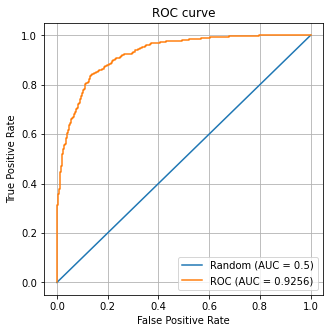

In [11]:
draw_ROC_curve(ensemble_model.predict_proba(X_test)[:, 1], y_test)

In [12]:
test = pd.read_csv('../randomforest/kma_test.csv')
test_input = test.drop(columns=['id', 'rainfall'])
test_output = test['rainfall']

In [13]:
predict = ensemble_model.predict(test_input)

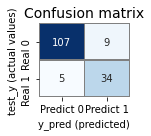


Accuracy:  0.91
Precision: 10.00
Recall:    6.00
F1 score:  7.50



In [14]:
draw_confusion_matrix(test_output, predict)

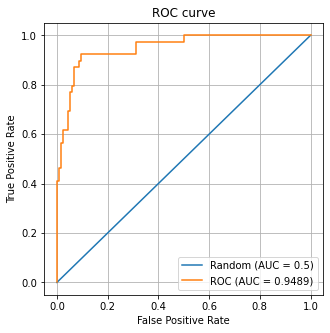

In [15]:
draw_ROC_curve(ensemble_model.predict_proba(test_input)[:, 1], test_output)

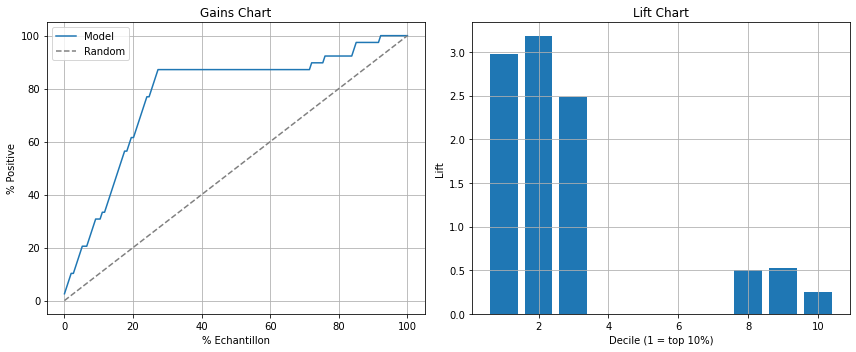

Lift based on meanResponse 2.980769230769231
Expected cumulative price for 10% random sales 3.9
Lift of the first decile (top 10%) : 2.98


In [16]:
Gain_Lift_Chart(test_output, predict)